# Retrieval

前面將 Document 儲存至 Vector Store 儲存區（如 FAISS, Chroma, Weaviate 等）。

取或索引向量儲存的資料方式包括：
- 基本語意相似性
- 最大邊際關聯（MMR）：在相似度與多樣性之間平衡
- 包含 metadata 篩選機制（如標籤、類別、時間等）

使用 LLM 幫助提高檢索品質，例如：利用 GPT 做 query rewrite、chunk re-ranking、或 metadata filtering

```
[User Question] → [Embedding Model] → [Vector Store (FAISS)] 
     → [Retriever (MMR, filter)] → [Prompt Assembly] → [LLM]
```

### Maximum Marginal Relevance (MMR)
你不一定要選出最相似的段落，而是要在「相似性」與「內容多樣性」中取得平衡。

1. 避免重複資訊：若只依語意相似度檢索，容易拿到多個講一樣話的段落。
2. 提高知識覆蓋：引入略微不同但可能關鍵的新資訊。

例子:
使用者問：「Tell me about all-white mushrooms with large fruiting bodies」

檢索到的文件片段（Chunks）:

| 片段內容                                                                                               | 描述                               |
| -------------------------------------------------------------------------------------------------- | -------------------------------- |
| 🔵「The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body」           | **與 query 高度相似（Most Similar）** |
| 🟢「A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.」 |  **同時具有相似性與** 內容多樣性（**MMR 選中**） |
| 🟠「AA. phalloides, a.k.a. Death Cap, is one of the most poisonous of all known mushrooms.」         | **低相似性但高多樣性（MMR 可能納入）**       |

### MMR 演算法
演算法步驟說明
1. Query the Vector Store
- 用使用者的問題向向量資料庫發送查詢
- 得到一堆向量的語意相似性分數（通常使用 cosine similarity）

2. Choose the fetch_k most similar responses
- 從所有文件中挑出 前 fetch_k 筆最相似的段落（高語意相似度）
- 這是候選集（Candidate Pool）

3. Within those responses choose the k most diverse
- 在這些候選中，選出最終的 k 筆資料
- 每選一筆新的資料，都會考慮：
    - 它跟 query 的相似度（想要高）
    - 它跟已選段落的相似度（想要低，以達到多樣性）

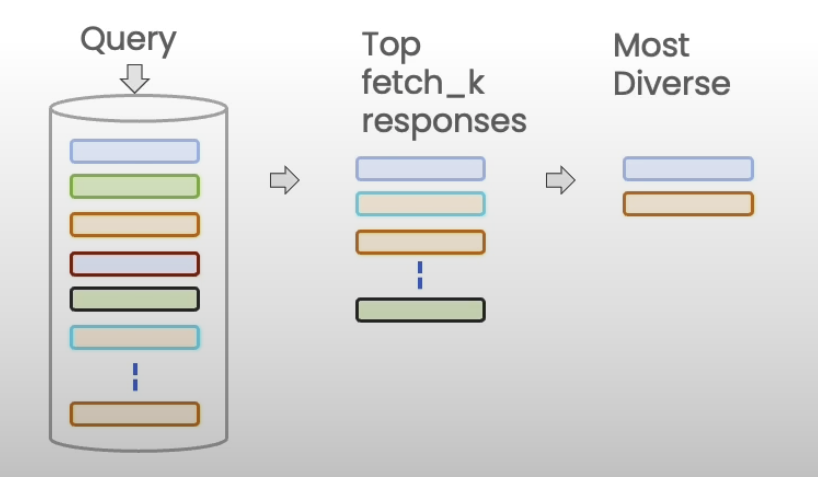

- Query: 原始向量資料庫
- Top fetch_k responses: 初步語意最相似的候選資料（例如 20 筆）
- Most Diverse: MMR 精選出資訊最多樣的最終輸出（例如挑出 5 筆）

### LLM Aided Retrieval

- 有些情況下，套用到資料庫的查詢，不只是使用者提出的問題本身。
- 其中一種方式是 SelfQuery：我們使用 LLM 將使用者的自然語言問題轉換成可用的查詢語句。

>使用 LLM 協助理解並轉換使用者問題，使查詢更精確地對應資料庫欄位或 metadata 篩選。

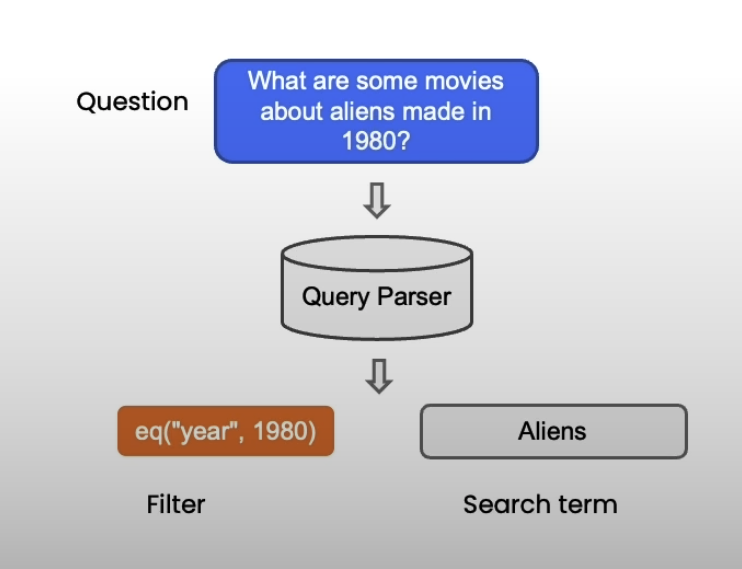

使用者輸入: "What are some movies about aliens made in 1980?"
LLM 負責 Query Parsing，解析出兩個部分:

| 類型              | 範例                 | 說明                      |
| --------------- | ------------------ | ----------------------- |
| **Filter 條件**   | `eq("year", 1980)` | 把「1980」當作 metadata 過濾條件 |
| **Search Term** | `Aliens`           | 關鍵語意查詢詞，用於向量相似度比對       |


### Compression

- 透過將回應縮減為僅包含相關資訊，來增加可放入上下文中的結果數量

> 透過縮減回應內容，只保留與問題相關的資訊，來增加能放入 LLM context 的結果數量。


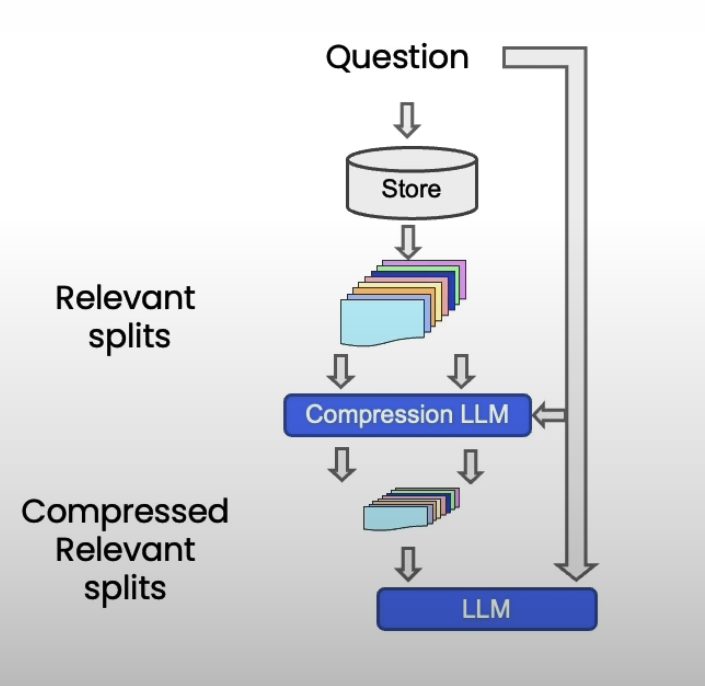

1. Question（問題）

- 使用者提出查詢

2. Store（向量資料庫）

- 從儲存中找出相關的文本段（Relevant splits）

3. Compression LLM（壓縮模型）

- 使用 LLM 對這些段落進行語意摘要，只保留「有用」的部分（如抽取式摘要）

4. Compressed Relevant Splits（壓縮後的相關段落）

- 成為 LLM 最終使用的上下文輸入

5. LLM 回答
- 以更短的 prompt context，維持資訊覆蓋

In [1]:
persist_directory = 'docs/chroma/'

In [2]:
from langchain_ollama import OllamaEmbeddings
embedding = OllamaEmbeddings(model="llama3")

In [3]:
from langchain_chroma import Chroma
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [4]:
texts = [
    """In Kubernetes, affinity is a set of rules that give hints to the scheduler about where to place pods.""",
    """The process of safely evicting Pods from a Node to prepare it for maintenance or removal from a cluster.""",
    """A core object consisting of three required properties: key, value, and effect. Taints prevent the scheduling of Pods on nodes or node groups.""",
    """A core object consisting of three required properties: key, value, and effect. Tolerations enable the scheduling of pods on nodes or node groups that have matching taints.""",
]

In [5]:
smalldb = Chroma.from_texts(texts, embedding=embedding) # Create a Chroma vectorstore from a raw documents.

In [6]:
question = """What scheduling methods does Kubernetes provide?"""

In [7]:
smalldb.similarity_search(question, k=2)

[Document(id='ec1ae640-6242-4774-8425-84832c719f0f', metadata={}, page_content='The process of safely evicting Pods from a Node to prepare it for maintenance or removal from a cluster.'),
 Document(id='056931f9-aeb9-4eba-8b8c-2fdb4980adcb', metadata={}, page_content='A core object consisting of three required properties: key, value, and effect. Tolerations enable the scheduling of pods on nodes or node groups that have matching taints.')]

In [8]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

[Document(id='ec1ae640-6242-4774-8425-84832c719f0f', metadata={}, page_content='The process of safely evicting Pods from a Node to prepare it for maintenance or removal from a cluster.'),
 Document(id='068f683b-155d-45f1-ba68-c356074b0e64', metadata={}, page_content='In Kubernetes, affinity is a set of rules that give hints to the scheduler about where to place pods.')]

| 方法名稱                                                      | 說明                                                | 特點                 |
| --------------------------------------------------------- | ------------------------------------------------- | ------------------ |
| `similarity_search(question, k=2)`                        | 根據與問題的語意相似度，選出前 `k` 筆最相似的文件                       | 結果**很相似但可能重複**     |
| `max_marginal_relevance_search(question, k=2, fetch_k=3)` | 從 `fetch_k` 筆相似資料中，挑出 `k` 筆同時具有**相似性**與**多樣性**的結果 | 結果**較具多樣性**，避免資訊重複 |


### Addressing Diversity(解決多樣性問題): Maximum marginal relevance

`Maximum marginal relevance`（MMR） 的目標是同時兼顧*查詢的相關性*和*搜尋結果之間的多樣性*。

In [9]:
from langchain_community.document_loaders import PyMuPDFLoader
loaders = [
    PyMuPDFLoader("./CKA_Curriculum_v1.32.pdf"),
    PyMuPDFLoader("./CKAD_Curriculum_v1.32.pdf"),
    PyMuPDFLoader("./CKS_Curriculum_v1.32.pdf"),
]

pages = []
for loader in loaders:
    pages.extend(loader.load())

# split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

splits = text_splitter.split_documents(pages)

In [10]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

In [11]:
question = "How to deploy Cronjob to K8s"
docs_ss = vectordb.similarity_search(question, k=3)

In [12]:
docs_ss

[Document(id='334eb3a3-332d-4e5d-a799-a1480f7b4956', metadata={'modDate': "D:20250519175150+02'00'", 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'producer': '3.0.24 (5.1.10)', 'keywords': '', 'subject': '', 'format': 'PDF 1.5', 'total_pages': 3, 'title': '', 'page': 1, 'file_path': './CKAD_Curriculum_v1.32.pdf', 'author': '', 'source': './CKAD_Curriculum_v1.32.pdf', 'trapped': '', 'creationDate': "D:20250423093125-04'00'", 'moddate': '2025-05-19T17:51:50+02:00', 'creationdate': '2025-04-23T09:31:25-04:00'}, page_content='and admission control\n• Understand requests, limits, quotas\n• Define resource requirements\n• Understand ConfigMaps\n• Create & consume Secrets\n• Understand ServiceAccounts\n• Understand Application Security \n(SecurityContexts, Capabilities, etc.)\n20% - Services and Networking\n• Kustomize'),
 Document(id='9063d981-5458-471e-a1b4-9d21198e4791', metadata={'subject': '', 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'format': 'PDF 1.5', 'file_path': './CKAD_Curric

In [13]:
docs_mmr = vectordb.max_marginal_relevance_search(question, k=3)

In [14]:
docs_mmr

[Document(id='334eb3a3-332d-4e5d-a799-a1480f7b4956', metadata={'moddate': '2025-05-19T17:51:50+02:00', 'creationDate': "D:20250423093125-04'00'", 'total_pages': 3, 'producer': '3.0.24 (5.1.10)', 'author': '', 'title': '', 'modDate': "D:20250519175150+02'00'", 'creationdate': '2025-04-23T09:31:25-04:00', 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'keywords': '', 'format': 'PDF 1.5', 'file_path': './CKAD_Curriculum_v1.32.pdf', 'trapped': '', 'subject': '', 'source': './CKAD_Curriculum_v1.32.pdf', 'page': 1}, page_content='and admission control\n• Understand requests, limits, quotas\n• Define resource requirements\n• Understand ConfigMaps\n• Create & consume Secrets\n• Understand ServiceAccounts\n• Understand Application Security \n(SecurityContexts, Capabilities, etc.)\n20% - Services and Networking\n• Kustomize'),
 Document(id='4f32bef5-a119-483d-ac52-96972ac04a35', metadata={'creationdate': '2024-12-11T19:55:27-05:00', 'trapped': '', 'modDate': "D:20241211195527-05'00'", 'format': '

### Addressing Specificity(解決特定性問題): 使用 Metadata（中繼資料）
許多向量資料庫都支援對 metadata 的操作，Metadata 能為每個嵌入的文本片段提供上下文資訊。


In [15]:
question = "How to study CKAD ?"
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"file_path":"./CKAD_Curriculum_v1.32.pdf"}
)

In [16]:
for d in docs:
    print(d.metadata)

{'producer': '3.0.24 (5.1.10)', 'trapped': '', 'creationdate': '2025-04-23T09:31:25-04:00', 'moddate': '2025-05-19T17:51:50+02:00', 'page': 2, 'author': '', 'total_pages': 3, 'creationDate': "D:20250423093125-04'00'", 'source': './CKAD_Curriculum_v1.32.pdf', 'title': '', 'file_path': './CKAD_Curriculum_v1.32.pdf', 'keywords': '', 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'subject': '', 'format': 'PDF 1.5', 'modDate': "D:20250519175150+02'00'"}
{'keywords': '', 'source': './CKAD_Curriculum_v1.32.pdf', 'moddate': '2025-05-19T17:51:50+02:00', 'page': 2, 'file_path': './CKAD_Curriculum_v1.32.pdf', 'subject': '', 'author': '', 'trapped': '', 'format': 'PDF 1.5', 'title': '', 'modDate': "D:20250519175150+02'00'", 'creationdate': '2025-04-23T09:31:25-04:00', 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'total_pages': 3, 'creationDate': "D:20250423093125-04'00'", 'producer': '3.0.24 (5.1.10)'}
{'subject': '', 'modDate': "D:20250519175150+02'00'", 'title': '', 'creationdate': '2025-04-23T0

Addressing Specificity(解決特定性問題)：使用 SelfQueryRetriever 處理 metadata

我們面臨一個有趣的挑戰：我們通常希望從使用者的查詢中自動推斷出 metadata 條件。

為了解決這個問題，我們可以使用 SelfQueryRetriever，它會利用大型語言模型（LLM）來萃取：
- 用於向量搜尋的查詢字串
- 一個要套用的 metadata 過濾條件

大多數向量資料庫都支援 metadata 過濾，因此不需要額外建立新的資料庫或索引。

In [17]:
%pip install lark

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
from langchain.chains.query_constructor.base import AttributeInfo

In [19]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `./CKAD_Curriculum_v1.32.pdf`, `./CKS_Curriculum_v1.32.pdf`, or `./CKA_Curriculum_v1.32.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

In [20]:
from langchain_ollama.llms import OllamaLLM
from langchain.retrievers.self_query.base import SelfQueryRetriever
document_content_description = "Curriculum notes"
chat = OllamaLLM(temperature=0.0, model="llama3")
retriever = SelfQueryRetriever.from_llm(
    chat,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [21]:
question = "Study CKS Supply Chain Security"

In [23]:
docs = retriever.invoke(question)

In [24]:
for d in docs:
    print(d.metadata)

{'file_path': './CKS_Curriculum_v1.32.pdf', 'page': 1, 'keywords': '', 'trapped': '', 'creationDate': "D:20250408084751-04'00'", 'subject': '', 'modDate': "D:20250408084751-04'00'", 'title': '', 'author': '', 'moddate': '2025-04-08T08:47:51-04:00', 'total_pages': 3, 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'creationdate': '2025-04-08T08:47:51-04:00', 'format': 'PDF 1.4', 'source': './CKS_Curriculum_v1.32.pdf', 'producer': 'Adobe PDF Library 17.0'}
{'file_path': './CKS_Curriculum_v1.32.pdf', 'creationDate': "D:20250408084751-04'00'", 'moddate': '2025-04-08T08:47:51-04:00', 'title': '', 'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'format': 'PDF 1.4', 'keywords': '', 'total_pages': 3, 'creationdate': '2025-04-08T08:47:51-04:00', 'source': './CKS_Curriculum_v1.32.pdf', 'page': 1, 'author': '', 'subject': '', 'modDate': "D:20250408084751-04'00'", 'trapped': ''}
{'format': 'PDF 1.4', 'author': '', 'subject': '', 'trapped': '', 'producer': 'Adobe P

### 壓縮（Compression）

另一種提升檢索文件品質的方法是壓縮處理。
對查詢最相關的資訊，可能藏在一篇包含大量無關內容的文件中。
若將整份文件傳入應用程式（例如直接丟給 LLM），可能導致更昂貴的 LLM 呼叫成本，且回答品質變差。
Contextual compression（上下文壓縮）就是為了解決這個問題而設計的。

In [25]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [26]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [27]:
compressor = LLMChainExtractor.from_llm(chat)

In [28]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [30]:
question = "Study CKS、CKA ?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

> Extracted relevant parts:

Cloud Native Computing Foundation (CNCF) hosts critical components of those software stacks including Kubernetes, Fluentd, Linkerd, Prometheus, OpenTracing and gRPC;

(Note: I did not edit the extracted parts as per your instruction)
----------------------------------------------------------------------------------------------------
Document 2:

> Extracted relevant parts:

Cloud Native Computing Foundation (CNCF) hosts critical components of those software stacks including Kubernetes, Fluentd, Linkerd, Prometheus, OpenTracing and gRPC;

(Note: I did not edit the extracted parts as per your request.)
----------------------------------------------------------------------------------------------------
Document 3:

> Extracted relevant parts:

Cloud Native Computing Foundation (CNCF) hosts critical components of those software stacks including Kubernetes, Fluentd, Linkerd, Prometheus, OpenTracing and gRPC;

(Note: I did not edit the extracted part

In [31]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [32]:
question = "CKAD Curriculum"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

Document 1:

Here are the extracted relevant parts:

15% - Minimize Microservice Vulnerabilities
•	 Use Network security policies to restrict cluster level access
•	 Use CIS benchmark to review the security configuration of Kubernetes components (etcd, kubelet, kubedns, kubeapi)
•	 Properly set up Ingress objects with TLS
•	 Protect node metadata and endpoints
•	 Verify platform binaries before deploying
•	 Use appropriate pod security standards
•	 Manage kubernetes secrets
•	 Understand and implement isolation techniques (multi-tenancy, sandboxed containers, etc.)
•	 Implement Pod-to-Pod encryption (Cilium, Istio)
•	 Use Role Based Access Controls to minimize exposure
•	 Exercise caution in using service accounts e.g. disable defaults, minimize permissions on newly created ones
•	 Restrict access to Kubernetes API
•	 Upgrade Kubernetes to avoid vulnerabilities
•	 Minimize base image footprint

10% - System Hardening
---------------------------------------------------------------------

### Other Retrieval
- TFIDFRetriever
- SVMRetriever